In [151]:
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
import numpy as np
from adjustText import adjust_text
pd.options.display.float_format = '{:.2f}'.format

In [3]:
with open('data/spring_2023/full_df.pkl', 'rb') as file:
    full_df = pkl.load(file)

len(full_df)

1247140

In [4]:

full_df = full_df.drop_duplicates(subset = ['item_name', 'store_id']) # need this because the same item might be listed under multiple categories
len(full_df)

full_df['state'], full_df['city'] = zip(*full_df['location_url'].str.split('/').str[3:5])

In [132]:
# full_df['item_name'].unique().tolist()

In [97]:

core_items = [
              'Supreme Taco Party Pack', 
            #   'Chicken Quesadilla', 
            #   'Cinnabon Delights® 12 Pack', 
            #   'Crunchwrap Supreme®', 
            #   'Beefy 5 Layer Burrito', 
            #   'Nacho Cheese Doritos Locos Taco', 
            #   '3 Doritos Locos Tacos Combo'
              ]

working = full_df[full_df['item_name'].isin(core_items)]

In [146]:
agg_funcs = {
    'mean': 'mean',
    'median': 'median',
    'num_stores': 'size',
    'nunique_prices': 'nunique',
    'max': 'max',
    'min': 'min',
    'sd': 'std'
}

########## in aggregate

# metric = 'median'
metric = 'mean'

state_distro = working.groupby(['state', 'item_name'])['value'].agg(**agg_funcs).sort_values(by = ['item_name', metric], ascending = False).reset_index()

item_distro = working.groupby('item_name')['value'].agg(**agg_funcs).sort_values(by = ['item_name', metric], ascending = False).reset_index()


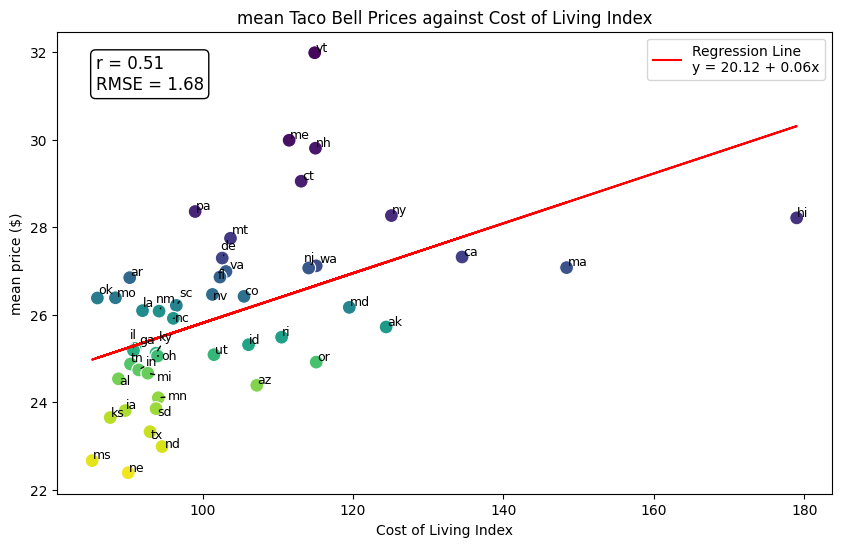

In [165]:

y = 'mean'
x = 'Cost of Living Index'
merged = state_distro.merge(state_coli, how = 'left', left_on = 'state', right_on = 'abbrev')
slope, intercept, r_value, p_value, std_err = stats.linregress(merged[x], merged[y])
sns.scatterplot(x = merged[x],  y = merged[y], label='Data')
y_pred = intercept + slope * merged[x]

# plt.plot(merged[x], y_pred, color='red', label='Regression Line')
plt.close('all')

# Calculate R-squared and RMSE
r = r_value#**2
rmse = np.sqrt(np.mean((y_pred - merged[y])**2))

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=merged[x], y=merged[y], hue=merged['state'], palette="viridis", s=100, legend=False)


# Plot the regression line
plt.plot(merged[x], y_pred, color='red', label=f'Regression Line\ny = {intercept:.2f} + {slope:.2f}x')

# Annotate each point with the city name
# for i in range(len(merged)):
#     plt.text(merged[x].iloc[i], merged[y].iloc[i], merged['state'].iloc[i], fontsize=9, ha='right')
texts = []
for i in range(len(merged)):
    texts.append(plt.text(merged[x].iloc[i], merged[y].iloc[i], merged['state'].iloc[i], fontsize=9))

# Adjust the positions of the labels to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

# Add R-squared and RMSE to the plot
plt.text(0.05, 0.95, f'r = {r:.2f}\nRMSE = {rmse:.2f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))


# Add labels and title
plt.xlabel(x)
plt.ylabel(f'{y} price ($)')
plt.title(f'{y} Taco Bell Prices against Cost of Living Index')
plt.legend()

# Show the plot
plt.show()


In [105]:
def visualize_deviations(state_distro, bounds, graph_col = 'mean', nbins=20, title='Histogram of Mean Values by State'):
    
    # Calculate statistics
    mean_value = state_distro[graph_col].mean()
    # print(mean_value)
    median_value = state_distro[graph_col].median()  # Uncommented for proper usage
    
    # Adjust plus_val and minus_val based on mean
    plus_val = mean_value * (1 + bounds)  # Apply the plus_val percentage to the mean
    minus_val = mean_value * (1 - bounds)  # Apply the minus_val percentage to the mean
    
    # Calculate the percentage of data within the range
    pct_data_in_range = len(state_distro[(state_distro[graph_col] >= minus_val) & (state_distro[graph_col] <= plus_val)]) / len(state_distro)
    
    # Create the histogram
    fig = px.histogram(state_distro, x=graph_col, nbins=nbins, title=title)
    # Adding black lines around each bin
    fig.update_traces(marker_line_color='black', marker_line_width=1.5)

    # Add vertical lines for the mean, plus_val, and minus_val
    fig.add_vline(x=median_value, line=dict(color='green', dash='dash'))
    fig.add_vline(x=plus_val, line=dict(color='red', dash='dash'))
    fig.add_vline(x=minus_val, line=dict(color='purple', dash='dash'))
    
    # Add annotations for clarity
    fig.add_annotation(x=mean_value, y=0, text=graph_col, showarrow=True, arrowhead=1, ax=0, ay=-40)
    fig.add_annotation(x=plus_val, y=0, text="Plus Value", showarrow=True, arrowhead=1, ax=0, ay=-40)
    fig.add_annotation(x=minus_val, y=0, text="Minus Value", showarrow=True, arrowhead=1, ax=0, ay=-40)
    
    # Add annotation for the percentage of data within the range
    fig.add_annotation(
        text=f"""The amount of data within the bands is {round(pct_data_in_range * 100, 1)}%\n
              """,
        xref="paper", yref="paper",
        x=0, y=1,
        showarrow=False,
        font=dict(size=12),
        align="left",
        xanchor='left',
        yanchor='top'
    )
    
    # Show the figure
    fig.show()

        # text=f"""The amount of data within the bands is {round(pct_data_in_range * 100, 1)}%\n
        # The mean value is {mean_value}\n
        # The upper bound is {plus_val}\n
        # The lower bound is {minus_val}\n
        #       """,


In [100]:
bounds = .1
# visualize_deviations(state_distro, bounds, nbins=20, title='Histogram of Mean Values by State')

In [68]:
bounds = .15
visualize_deviations(state_distro, bounds, nbins=20, title='Histogram of Mean Values by State')

In [106]:
bounds = .15
visualize_deviations(working, bounds, graph_col = 'value', nbins=100, title = 'all prices')

In [86]:
# bounds = .15
# visualize_deviations(working[~working['state'].isin(['hi', 'ak'])], bounds, graph_col = 'value', nbins=100, title = 'all prices') 

In [91]:
len(working)
len(working[~working['state'].isin(['hi', 'ak'])])
state_distro
item_distro

,item_name,mean,median,num_stores,nunique_prices,max,min,sd
0,Supreme Taco Party Pack,25.76,25.99,7036,71,39.99,0.00,3.40
1,Crunchwrap Supreme®,5.28,5.19,7036,42,8.49,0.00,0.57
2,Chicken Quesadilla,5.41,5.39,7037,43,8.29,0.00,0.64


/Users/arjungupta/Documents/projects/taco-bell/myenv/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning:

Unverified HTTPS request is being made to host 'worldpopulationreview.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings

/var/folders/r8/1njvdjqs71vfshzknvlgyy_h0000gn/T/ipykernel_4096/1835256902.py:9: FutureWarning:

Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.

